In [259]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
from statistics import mean

In [2]:
df = pd.read_csv('GPT-wiki-intro.csv', na_values="?")

In [3]:
df.head(5)

,id,url,title,wiki_intro,generated_intro,title_len,wiki_intro_len,generated_intro_len,prompt,generated_text,prompt_tokens,generated_text_tokens
0,63064638,https://en.wikipedia.org/wiki/Sexhow%20railway...,Sexhow railway station,Sexhow railway station was a railway station b...,Sexhow railway station was a railway station l...,3,174,78,200 word wikipedia style introduction on 'Sexh...,"located in the town of Sexhow, on the Cumbria...",25,88
1,279621,https://en.wikipedia.org/wiki/Eti%C3%A4inen,Etiäinen,"In Finnish folklore, all places and things, an...","In Finnish folklore, all places and things, an...",1,187,80,200 word wikipedia style introduction on 'Etiä...,"animate or inanimate, have a spirit or ""etiäi...",26,101
2,287229,https://en.wikipedia.org/wiki/Inverse%20functi...,Inverse function theorem,"In mathematics, specifically differential calc...","In mathematics, specifically differential calc...",3,170,59,200 word wikipedia style introduction on 'Inve...,function theorem states that for every real-v...,26,65
3,26712375,https://en.wikipedia.org/wiki/Stepping%20on%20...,Stepping on Roses,is a Japanese shōjo manga series written and i...,is a Japanese shōjo manga series written and i...,3,335,121,200 word wikipedia style introduction on 'Step...,and illustrated by Maki Fujii. The series fol...,26,150
4,38894426,https://en.wikipedia.org/wiki/Rob%20Bradley,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...","Robert Milner ""Rob"" Bradley, Jr. (born August ...",2,170,136,200 word wikipedia style introduction on 'Rob ...,"29, 1973) is an American former professional ...",28,162


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   id                     150000 non-null  int64 
 1   url                    150000 non-null  object
 2   title                  150000 non-null  object
 3   wiki_intro             150000 non-null  object
 4   generated_intro        150000 non-null  object
 5   title_len              150000 non-null  int64 
 6   wiki_intro_len         150000 non-null  int64 
 7   generated_intro_len    150000 non-null  int64 
 8   prompt                 150000 non-null  object
 9   generated_text         150000 non-null  object
 10  prompt_tokens          150000 non-null  int64 
 11  generated_text_tokens  150000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 13.7+ MB


In [5]:
df['wiki_intro']

0         Sexhow railway station was a railway station b...
1         In Finnish folklore, all places and things, an...
2         In mathematics, specifically differential calc...
3         is a Japanese shōjo manga series written and i...
4         Robert Milner "Rob" Bradley, Jr. (born August ...
                                ...                        
149995    Randy Borum is a Professor and Coordinator of ...
149996    Sa'och (, also, "Sauch") is an endangered, nea...
149997    Philip C. Hanawalt (born 1931) is an American ...
149998    Vossius Gymnasium is a public gymnasium in Ams...
149999    Simone Stratigo (, Symeon Filippos Stratigos; ...
Name: wiki_intro, Length: 150000, dtype: object

In [6]:
df['generated_intro']

0         Sexhow railway station was a railway station l...
1         In Finnish folklore, all places and things, an...
2         In mathematics, specifically differential calc...
3         is a Japanese shōjo manga series written and i...
4         Robert Milner "Rob" Bradley, Jr. (born August ...
                                ...                        
149995    Randy Borum is a Professor and Coordinator of ...
149996    Sa'och (, also, "Sauch") is an endangered, nuc...
149997    Philip C. Hanawalt (born 1931) is an American ...
149998    Vossius Gymnasium is a public gymnasium in the...
149999    Simone Stratigo (, Symeon Filippos Stratigos; ...
Name: generated_intro, Length: 150000, dtype: object

In [7]:
print(df['wiki_intro_len'].max())
print(df['generated_intro_len'].max())

350
278


### Reshaping the data

In [8]:
data = pd.concat([df['wiki_intro'], df['generated_intro']], axis=0)

In [9]:
data = data.reset_index(drop=True)

In [10]:
data = data.to_frame()

In [11]:
data.columns = ['Text']

In [12]:
data

,Text
0,Sexhow railway station was a railway station b...
1,"In Finnish folklore, all places and things, an..."
2,"In mathematics, specifically differential calc..."
3,is a Japanese shōjo manga series written and i...
4,"Robert Milner ""Rob"" Bradley, Jr. (born August ..."
...,...
299995,Randy Borum is a Professor and Coordinator of ...
299996,"Sa'och (, also, ""Sauch"") is an endangered, nuc..."
299997,Philip C. Hanawalt (born 1931) is an American ...
299998,Vossius Gymnasium is a public gymnasium in the...


In [13]:
humans = ['Human'] * 150000

In [14]:
gpt = ['GPT'] * 150000

In [15]:
classes = humans + gpt

In [16]:
len(classes)

300000

In [17]:
data['Class'] = classes

In [18]:
data

,Text,Class
0,Sexhow railway station was a railway station b...,Human
1,"In Finnish folklore, all places and things, an...",Human
2,"In mathematics, specifically differential calc...",Human
3,is a Japanese shōjo manga series written and i...,Human
4,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",Human
...,...,...
299995,Randy Borum is a Professor and Coordinator of ...,GPT
299996,"Sa'och (, also, ""Sauch"") is an endangered, nuc...",GPT
299997,Philip C. Hanawalt (born 1931) is an American ...,GPT
299998,Vossius Gymnasium is a public gymnasium in the...,GPT


### Subset of data

Using all 300000 data points to train even a simple model takes a long time. As such, I'll take a subset of data to apply to my baseline model

In [19]:
subset = data.sample(n=10000, axis=0, random_state=3)

In [20]:
subset['Class'].value_counts()

Human    5003
GPT      4997
Name: Class, dtype: int64

In [21]:
vectorizer = CountVectorizer()

In [22]:
X = vectorizer.fit_transform(subset['Text'])

In [23]:
y = subset['Class'].to_numpy()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 1 layer of 100 nodes

In [25]:
mlp = MLPClassifier(verbose=True)

In [26]:
start = time.time()
mlp.fit(X_train, y_train)
stop = time.time()

Iteration 1, loss = 0.41409888
Iteration 2, loss = 0.07160375
Iteration 3, loss = 0.01818894
Iteration 4, loss = 0.00755935
Iteration 5, loss = 0.00405087
Iteration 6, loss = 0.00262048
Iteration 7, loss = 0.00187419
Iteration 8, loss = 0.00143601
Iteration 9, loss = 0.00115586
Iteration 10, loss = 0.00096697
Iteration 11, loss = 0.00083347
Iteration 12, loss = 0.00073547
Iteration 13, loss = 0.00066121
Iteration 14, loss = 0.00060321
Iteration 15, loss = 0.00055711
Iteration 16, loss = 0.00051998
Iteration 17, loss = 0.00048904
Iteration 18, loss = 0.00046332
Iteration 19, loss = 0.00044162
Iteration 20, loss = 0.00042277
Iteration 21, loss = 0.00040646
Iteration 22, loss = 0.00039214
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [27]:
accuracy = mlp.score(X_test, y_test)

In [28]:
y_pred = mlp.predict(X_test)

In [29]:
print(f"Training time: {stop - start:.2f} seconds")

Training time: 274.55 seconds


In [30]:
accuracy

0.892

In [31]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         GPT       0.92      0.86      0.89      1022
       Human       0.87      0.92      0.89       978

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [32]:
print(confusion_matrix(y_pred, y_test))

[[884 138]
 [ 78 900]]


This most basic model with the default parameters of a single layer of 100 nodes performs surprisingly well at 90.01%. The accuracy is affected by the data points choosen during the random sampling and distribution of classes within that sample. As such, resampling and retraining the model would likely result in a slightly different accuracy. 

### 2 layers of 100 nodes

In [33]:
mlp2l = MLPClassifier(hidden_layer_sizes=(100,100,), verbose=True)

In [34]:
start2l = time.time()
mlp2l.fit(X_train, y_train)
stop2l = time.time()

Iteration 1, loss = 0.43224171
Iteration 2, loss = 0.04735020
Iteration 3, loss = 0.00558871
Iteration 4, loss = 0.00158460
Iteration 5, loss = 0.00087621
Iteration 6, loss = 0.00054946
Iteration 7, loss = 0.00035858
Iteration 8, loss = 0.00024903
Iteration 9, loss = 0.00020441
Iteration 10, loss = 0.00018380
Iteration 11, loss = 0.00017243
Iteration 12, loss = 0.00016480
Iteration 13, loss = 0.00015926
Iteration 14, loss = 0.00015509
Iteration 15, loss = 0.00015163
Iteration 16, loss = 0.00014875
Iteration 17, loss = 0.00014627
Iteration 18, loss = 0.00014405
Iteration 19, loss = 0.00014207
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [35]:
accuracy2l = mlp2l.score(X_test, y_test)

In [36]:
y_pred2l = mlp2l.predict(X_test)

In [37]:
print(f"Training time: {stop2l - start2l:.2f} seconds")

Training time: 238.01 seconds


In [38]:
accuracy2l

0.893

In [39]:
print(classification_report(y_pred2l, y_test))

              precision    recall  f1-score   support

         GPT       0.93      0.86      0.89      1040
       Human       0.86      0.93      0.89       960

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



In [40]:
print(confusion_matrix(y_pred2l, y_test))

[[894 146]
 [ 68 892]]


### 3 layers of 100 nodes

In [41]:
mlp3l = MLPClassifier(hidden_layer_sizes=(100,100,100), verbose=True)

In [42]:
start3l = time.time()
mlp3l.fit(X_train, y_train)
stop3l = time.time()

Iteration 1, loss = 0.42039000
Iteration 2, loss = 0.03827939
Iteration 3, loss = 0.00308067
Iteration 4, loss = 0.00076904
Iteration 5, loss = 0.00038092
Iteration 6, loss = 0.00027163
Iteration 7, loss = 0.00021841
Iteration 8, loss = 0.00018863
Iteration 9, loss = 0.00017282
Iteration 10, loss = 0.00016332
Iteration 11, loss = 0.00015698
Iteration 12, loss = 0.00015228
Iteration 13, loss = 0.00014871
Iteration 14, loss = 0.00014567
Iteration 15, loss = 0.00014317
Iteration 16, loss = 0.00014098
Iteration 17, loss = 0.00013901
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [43]:
accuracy3l = mlp3l.score(X_test, y_test)

In [44]:
y_pred3l = mlp3l.predict(X_test)

In [45]:
print(f"Training time: {stop - start:.2f} seconds")

Training time: 274.55 seconds


In [46]:
accuracy3l

0.8955

In [47]:
print(classification_report(y_pred3l, y_test))

              precision    recall  f1-score   support

         GPT       0.93      0.87      0.90      1029
       Human       0.87      0.93      0.90       971

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [48]:
print(confusion_matrix(y_pred3l, y_test))

[[891 138]
 [ 71 900]]


### 4 layers of 100 nodes

In [49]:
mlp4l = MLPClassifier(hidden_layer_sizes=(100,100,100,100,), verbose=True)

In [50]:
start4l = time.time()
mlp4l.fit(X_train, y_train)
stop4l = time.time()

Iteration 1, loss = 0.39780059
Iteration 2, loss = 0.03446934
Iteration 3, loss = 0.00263124
Iteration 4, loss = 0.00052959
Iteration 5, loss = 0.00027068
Iteration 6, loss = 0.00021068
Iteration 7, loss = 0.00018869
Iteration 8, loss = 0.00017752
Iteration 9, loss = 0.00017026
Iteration 10, loss = 0.00016516
Iteration 11, loss = 0.00016134
Iteration 12, loss = 0.00015828
Iteration 13, loss = 0.00015546
Iteration 14, loss = 0.00015311
Iteration 15, loss = 0.00015109
Iteration 16, loss = 0.00014932
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [51]:
accuracy4l = mlp4l.score(X_test, y_test)

In [52]:
y_pred4l = mlp4l.predict(X_test)

In [53]:
print(f"Training time: {stop4l - start4l:.2f} seconds")

Training time: 201.28 seconds


In [54]:
accuracy4l

0.8955

In [55]:
print(classification_report(y_pred4l, y_test))

              precision    recall  f1-score   support

         GPT       0.93      0.86      0.90      1037
       Human       0.86      0.93      0.90       963

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [56]:
print(confusion_matrix(y_pred4l, y_test))

[[895 142]
 [ 67 896]]


### 5 layers of 100 nodes

In [57]:
mlp5l = MLPClassifier(hidden_layer_sizes=(100,100,100,100,100,), verbose=True)

In [58]:
start5l = time.time()
mlp5l.fit(X_train, y_train)
stop5l = time.time()

Iteration 1, loss = 0.37336361
Iteration 2, loss = 0.02698515
Iteration 3, loss = 0.00143886
Iteration 4, loss = 0.00080708
Iteration 5, loss = 0.00031846
Iteration 6, loss = 0.00023046
Iteration 7, loss = 0.00021070
Iteration 8, loss = 0.00019875
Iteration 9, loss = 0.00018773
Iteration 10, loss = 0.00017934
Iteration 11, loss = 0.00017636
Iteration 12, loss = 0.00017440
Iteration 13, loss = 0.00017264
Iteration 14, loss = 0.00017099
Iteration 15, loss = 0.00016946
Iteration 16, loss = 0.00016800
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [59]:
accuracy5l = mlp5l.score(X_test, y_test)

In [60]:
y_pred5l = mlp5l.predict(X_test)

In [61]:
print(f"Training time: {stop5l - start5l:.2f} seconds")

Training time: 201.20 seconds


In [62]:
accuracy5l

0.9045

In [63]:
print(classification_report(y_pred5l, y_test))

              precision    recall  f1-score   support

         GPT       0.90      0.90      0.90       961
       Human       0.91      0.91      0.91      1039

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [64]:
print(confusion_matrix(y_pred5l, y_test))

[[866  95]
 [ 96 943]]


In [255]:
x_axis=[1,2,3,4,5]
y_axis=[accuracy,accuracy2l,accuracy3l,accuracy4l,accuracy5l]

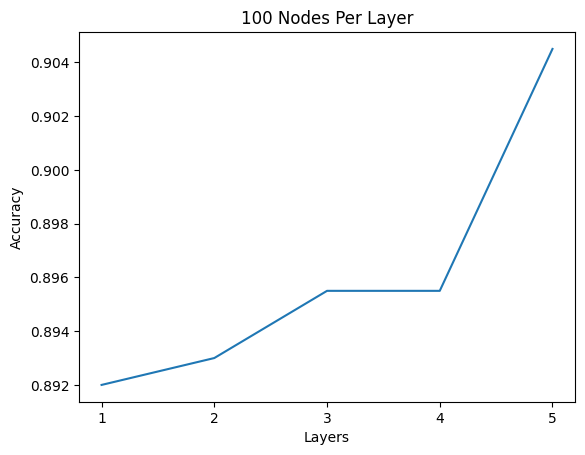

In [256]:
plt.plot(x_axis, y_axis)
plt.title('100 Nodes Per Layer')
plt.xticks(range(1,6))
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.show()

In [260]:
mean(y_axis)

0.8961

### 6 layers of 100 nodes

In [65]:
mlp6l = MLPClassifier(hidden_layer_sizes=(100,100,100,100,100,100,), verbose=True)

In [66]:
start6l = time.time()
mlp6l.fit(X_train, y_train)
stop6l = time.time()

Iteration 1, loss = 0.40148694
Iteration 2, loss = 0.04348769
Iteration 3, loss = 0.00428017
Iteration 4, loss = 0.00054531
Iteration 5, loss = 0.00027092
Iteration 6, loss = 0.00021682
Iteration 7, loss = 0.00020787
Iteration 8, loss = 0.00020393
Iteration 9, loss = 0.00020096
Iteration 10, loss = 0.00019847
Iteration 11, loss = 0.00019622
Iteration 12, loss = 0.00019410
Iteration 13, loss = 0.00019211
Iteration 14, loss = 0.00019025
Iteration 15, loss = 0.00018847
Iteration 16, loss = 0.00018675
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [67]:
accuracy6l = mlp6l.score(X_test, y_test)

In [68]:
y_pred6l = mlp6l.predict(X_test)

In [69]:
print(f"Training time: {stop6l - start6l:.2f} seconds")

Training time: 199.75 seconds


In [70]:
accuracy6l

0.8945

In [71]:
print(classification_report(y_pred6l, y_test))

              precision    recall  f1-score   support

         GPT       0.90      0.88      0.89       987
       Human       0.89      0.91      0.90      1013

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [72]:
print(confusion_matrix(y_pred5l, y_test))

[[866  95]
 [ 96 943]]


Instead of endlessly adding more layers, less also explore the result of adding more nodes per layer

### 1 layer of 200 nodes

In [73]:
mlp1l200 = MLPClassifier(hidden_layer_sizes=(200,), verbose=True)

In [74]:
start1l200 = time.time()
mlp1l200.fit(X_train, y_train)
stop1l200 = time.time()

Iteration 1, loss = 0.41579959
Iteration 2, loss = 0.06081531
Iteration 3, loss = 0.01326140
Iteration 4, loss = 0.00548226
Iteration 5, loss = 0.00292481
Iteration 6, loss = 0.00183475
Iteration 7, loss = 0.00128673
Iteration 8, loss = 0.00099223
Iteration 9, loss = 0.00081983
Iteration 10, loss = 0.00070957
Iteration 11, loss = 0.00063488
Iteration 12, loss = 0.00058134
Iteration 13, loss = 0.00054206
Iteration 14, loss = 0.00051118
Iteration 15, loss = 0.00048676
Iteration 16, loss = 0.00046633
Iteration 17, loss = 0.00044882
Iteration 18, loss = 0.00043360
Iteration 19, loss = 0.00042015
Iteration 20, loss = 0.00040801
Iteration 21, loss = 0.00039703
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [75]:
accuracy1l200 = mlp1l200.score(X_test, y_test)

In [76]:
y_pred1l200 = mlp.predict(X_test)

In [77]:
print(f"Training time: {stop1l200 - start1l200:.2f} seconds")

Training time: 545.03 seconds


In [78]:
accuracy1l200

0.8915

In [79]:
print(classification_report(y_pred1l200, y_test))

              precision    recall  f1-score   support

         GPT       0.92      0.86      0.89      1022
       Human       0.87      0.92      0.89       978

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [80]:
print(confusion_matrix(y_pred1l200, y_test))

[[884 138]
 [ 78 900]]


### 1 layer of 300 nodes

In [81]:
mlp1l300 = MLPClassifier(hidden_layer_sizes=(300,), verbose=True)

In [82]:
start1l300 = time.time()
mlp1l300.fit(X_train, y_train)
stop1l300 = time.time()

Iteration 1, loss = 0.38841091
Iteration 2, loss = 0.04301259
Iteration 3, loss = 0.00856191
Iteration 4, loss = 0.00360772
Iteration 5, loss = 0.00202925
Iteration 6, loss = 0.00130599
Iteration 7, loss = 0.00097484
Iteration 8, loss = 0.00080057
Iteration 9, loss = 0.00069827
Iteration 10, loss = 0.00063252
Iteration 11, loss = 0.00058636
Iteration 12, loss = 0.00055228
Iteration 13, loss = 0.00052572
Iteration 14, loss = 0.00050394
Iteration 15, loss = 0.00048557
Iteration 16, loss = 0.00046953
Iteration 17, loss = 0.00045546
Iteration 18, loss = 0.00044273
Iteration 19, loss = 0.00043111
Iteration 20, loss = 0.00042046
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [83]:
accuracy1l300 = mlp1l300.score(X_test, y_test)

In [84]:
y_pred1l300 = mlp.predict(X_test)

In [85]:
print(f"Training time: {stop1l300 - start1l300:.2f} seconds")

Training time: 838.71 seconds


In [86]:
accuracy1l300

0.896

In [87]:
print(classification_report(y_pred1l300, y_test))

              precision    recall  f1-score   support

         GPT       0.92      0.86      0.89      1022
       Human       0.87      0.92      0.89       978

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [88]:
print(confusion_matrix(y_pred1l300, y_test))

[[884 138]
 [ 78 900]]


Adding more layers to a single layer hurts the model. I'm curious to see what happens when I remove nodes from the original model.

### 1 layer of 50 nodes

In [89]:
mlp1l50 = MLPClassifier(hidden_layer_sizes=(50,), verbose=True)

In [90]:
start1l50 = time.time()
mlp1l50.fit(X_train, y_train)
stop1l50 = time.time()

Iteration 1, loss = 0.44689741
Iteration 2, loss = 0.10048897
Iteration 3, loss = 0.03208169
Iteration 4, loss = 0.01498861
Iteration 5, loss = 0.00862042
Iteration 6, loss = 0.00569372
Iteration 7, loss = 0.00396174
Iteration 8, loss = 0.00283998
Iteration 9, loss = 0.00212887
Iteration 10, loss = 0.00167199
Iteration 11, loss = 0.00135953
Iteration 12, loss = 0.00113925
Iteration 13, loss = 0.00097894
Iteration 14, loss = 0.00085785
Iteration 15, loss = 0.00076433
Iteration 16, loss = 0.00068984
Iteration 17, loss = 0.00063128
Iteration 18, loss = 0.00058264
Iteration 19, loss = 0.00054244
Iteration 20, loss = 0.00050866
Iteration 21, loss = 0.00047998
Iteration 22, loss = 0.00045536
Iteration 23, loss = 0.00043406
Iteration 24, loss = 0.00041550
Iteration 25, loss = 0.00039905
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [91]:
accuracy1l50 = mlp1l50.score(X_test, y_test)

In [92]:
y_pred1l50 = mlp.predict(X_test)

In [93]:
print(f"Training time: {stop1l50 - start1l50:.2f} seconds")

Training time: 162.36 seconds


In [94]:
accuracy1l50

0.8895

In [95]:
print(classification_report(y_pred1l50, y_test))

              precision    recall  f1-score   support

         GPT       0.92      0.86      0.89      1022
       Human       0.87      0.92      0.89       978

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [96]:
print(confusion_matrix(y_pred1l50, y_test))

[[884 138]
 [ 78 900]]


Decreasing the node count from the original 100 predictably lowered accuracy but increasing it did the same. Lets seem if multiple layers of more nodes will preform better.

### 2 layers of 200 nodes

In [97]:
mlp2l200 = MLPClassifier(hidden_layer_sizes=(200,200,), verbose=True)

In [98]:
start2l200 = time.time()
mlp2l200.fit(X_train, y_train)
stop2l200 = time.time()

Iteration 1, loss = 0.37862157
Iteration 2, loss = 0.02923880
Iteration 3, loss = 0.00447211
Iteration 4, loss = 0.00099946
Iteration 5, loss = 0.00055970
Iteration 6, loss = 0.00041154
Iteration 7, loss = 0.00034000
Iteration 8, loss = 0.00030006
Iteration 9, loss = 0.00027676
Iteration 10, loss = 0.00026221
Iteration 11, loss = 0.00025210
Iteration 12, loss = 0.00024481
Iteration 13, loss = 0.00023891
Iteration 14, loss = 0.00023406
Iteration 15, loss = 0.00022983
Iteration 16, loss = 0.00022610
Iteration 17, loss = 0.00022270
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [99]:
accuracy2l200 = mlp2l200.score(X_test, y_test)

In [100]:
y_pred2l200 = mlp.predict(X_test)

In [101]:
print(f"Training time: {stop2l200 - start2l200:.2f} seconds")

Training time: 491.35 seconds


In [102]:
accuracy2l200

0.89

In [103]:
print(classification_report(y_pred2l200, y_test))

              precision    recall  f1-score   support

         GPT       0.92      0.86      0.89      1022
       Human       0.87      0.92      0.89       978

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [104]:
print(confusion_matrix(y_pred2l200, y_test))

[[884 138]
 [ 78 900]]


### 3 layers of 200 nodes

In [133]:
mlp3l200 = MLPClassifier(hidden_layer_sizes=(200,200,200,), verbose=True)

In [134]:
start3l200 = time.time()
mlp3l200.fit(X_train, y_train)
stop3l200 = time.time()

Iteration 1, loss = 0.37333308
Iteration 2, loss = 0.02735626
Iteration 3, loss = 0.00163188
Iteration 4, loss = 0.00053890
Iteration 5, loss = 0.00033432
Iteration 6, loss = 0.00029265
Iteration 7, loss = 0.00027923
Iteration 8, loss = 0.00027155
Iteration 9, loss = 0.00026614
Iteration 10, loss = 0.00026176
Iteration 11, loss = 0.00025801
Iteration 12, loss = 0.00025457
Iteration 13, loss = 0.00025118
Iteration 14, loss = 0.00024811
Iteration 15, loss = 0.00024535
Iteration 16, loss = 0.00024276
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [137]:
accuracy3l200 = mlp3l200.score(X_test, y_test)

In [138]:
y_pred3l200 = mlp3l200.predict(X_test)

In [139]:
print(f"Training time: {stop3l200 - start3l200:.2f} seconds")

Training time: 417.23 seconds


In [140]:
accuracy3l200

0.889

In [141]:
print(classification_report(y_pred3l200, y_test))

              precision    recall  f1-score   support

         GPT       0.93      0.85      0.89      1058
       Human       0.85      0.93      0.89       942

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [142]:
print(confusion_matrix(y_pred3l200, y_test))

[[899 159]
 [ 63 879]]


### 4 layers of 200 nodes

In [147]:
mlp4l200 = MLPClassifier(hidden_layer_sizes=(200,200,200,200,), verbose=True)

In [148]:
start4l200 = time.time()
mlp4l200.fit(X_train, y_train)
stop4l200 = time.time()

Iteration 1, loss = 0.36418194
Iteration 2, loss = 0.02086079
Iteration 3, loss = 0.00271048
Iteration 4, loss = 0.00058638
Iteration 5, loss = 0.00036106
Iteration 6, loss = 0.00032079
Iteration 7, loss = 0.00030003
Iteration 8, loss = 0.00029086
Iteration 9, loss = 0.00028684
Iteration 10, loss = 0.00028362
Iteration 11, loss = 0.00028063
Iteration 12, loss = 0.00027779
Iteration 13, loss = 0.00027506
Iteration 14, loss = 0.00027243
Iteration 15, loss = 0.00026986
Iteration 16, loss = 0.00026738
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [149]:
accuracy4l200 = mlp4l200.score(X_test, y_test)

In [150]:
y_pred4l200 = mlp4l200.predict(X_test)

In [151]:
print(f"Training time: {stop4l200 - start4l200:.2f} seconds")

Training time: 455.42 seconds


In [152]:
accuracy4l200

0.903

In [153]:
print(classification_report(y_pred4l200, y_test))

              precision    recall  f1-score   support

         GPT       0.90      0.90      0.90       962
       Human       0.91      0.91      0.91      1038

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [154]:
print(confusion_matrix(y_pred4l200, y_test))

[[865  97]
 [ 97 941]]


### 5 layers of 200 nodes

In [163]:
mlp5l200 = MLPClassifier(hidden_layer_sizes=(200,200,200,200,200,), verbose=True)

In [164]:
start5l200 = time.time()
mlp5l200.fit(X_train, y_train)
stop5l200 = time.time()

Iteration 1, loss = 0.36794391
Iteration 2, loss = 0.02082986
Iteration 3, loss = 0.00160213
Iteration 4, loss = 0.00040361
Iteration 5, loss = 0.00034677
Iteration 6, loss = 0.00032772
Iteration 7, loss = 0.00031753
Iteration 8, loss = 0.00031020
Iteration 9, loss = 0.00030492
Iteration 10, loss = 0.00029981
Iteration 11, loss = 0.00029545
Iteration 12, loss = 0.00029210
Iteration 13, loss = 0.00028897
Iteration 14, loss = 0.00028597
Iteration 15, loss = 0.00028309
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [168]:
accuracy5l200 = mlp5l200.score(X_test, y_test)

In [169]:
y_pred5l200 = mlp5l200.predict(X_test)

In [170]:
print(f"Training time: {stop5l200 - start5l200:.2f} seconds")

Training time: 411.34 seconds


In [171]:
accuracy5l200

0.8975

In [172]:
print(classification_report(y_pred5l200, y_test))

              precision    recall  f1-score   support

         GPT       0.89      0.90      0.89       957
       Human       0.90      0.90      0.90      1043

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [173]:
print(confusion_matrix(y_pred5l200, y_test))

[[857 100]
 [105 938]]


In [261]:
x_axis=[1,2,3,4,5]
y_axis=[accuracy1l200,accuracy2l200,accuracy3l200,accuracy4l200,accuracy5l200]

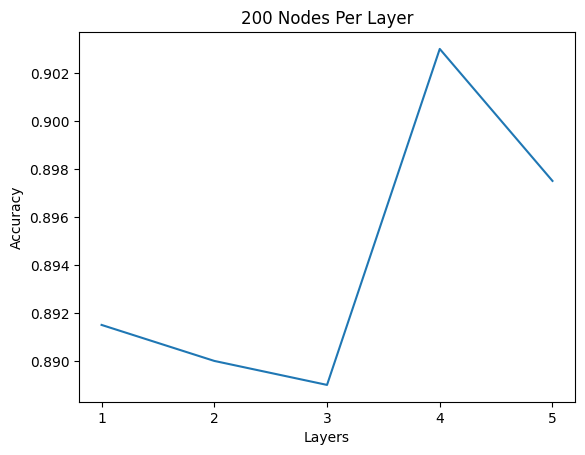

In [262]:
plt.plot(x_axis, y_axis)
plt.title('200 Nodes Per Layer')
plt.xticks(range(1,6))
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.show()

In [263]:
mean(y_axis)

0.8942

### 2 layers of 300 nodes

In [155]:
mlp2l300 = MLPClassifier(hidden_layer_sizes=(300,300,), verbose=True)

In [156]:
start2l300 = time.time()
mlp2l300.fit(X_train, y_train)
stop2l300 = time.time()

Iteration 1, loss = 0.36121106
Iteration 2, loss = 0.02681535
Iteration 3, loss = 0.00231895
Iteration 4, loss = 0.00086035
Iteration 5, loss = 0.00059569
Iteration 6, loss = 0.00049110
Iteration 7, loss = 0.00043508
Iteration 8, loss = 0.00039961
Iteration 9, loss = 0.00037483
Iteration 10, loss = 0.00035649
Iteration 11, loss = 0.00034200
Iteration 12, loss = 0.00033123
Iteration 13, loss = 0.00032281
Iteration 14, loss = 0.00031588
Iteration 15, loss = 0.00030991
Iteration 16, loss = 0.00030466
Iteration 17, loss = 0.00029987
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [157]:
accuracy2l300 = mlp2l300.score(X_test, y_test)

In [158]:
y_pred2l300 = mlp2l300.predict(X_test)

In [159]:
print(f"Training time: {stop2l300 - start2l300:.2f} seconds")

Training time: 687.31 seconds


In [160]:
accuracy2l300

0.8905

In [161]:
print(classification_report(y_pred2l300, y_test))

              precision    recall  f1-score   support

         GPT       0.92      0.86      0.89      1027
       Human       0.86      0.92      0.89       973

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [162]:
print(confusion_matrix(y_pred2l300, y_test))

[[885 142]
 [ 77 896]]


### 3 layers of 300 nodes

In [174]:
mlp3l300 = MLPClassifier(hidden_layer_sizes=(300,300,300,), verbose=True)

In [175]:
start3l300 = time.time()
mlp3l300.fit(X_train, y_train)
stop3l300 = time.time()

Iteration 1, loss = 0.37339865
Iteration 2, loss = 0.02596167
Iteration 3, loss = 0.00128840
Iteration 4, loss = 0.00053013
Iteration 5, loss = 0.00043529
Iteration 6, loss = 0.00039989
Iteration 7, loss = 0.00038094
Iteration 8, loss = 0.00036928
Iteration 9, loss = 0.00036097
Iteration 10, loss = 0.00035457
Iteration 11, loss = 0.00034920
Iteration 12, loss = 0.00034446
Iteration 13, loss = 0.00034007
Iteration 14, loss = 0.00033598
Iteration 15, loss = 0.00033209
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [176]:
accuracy3l300 = mlp3l300.score(X_test, y_test)

In [177]:
y_pred3l300 = mlp3l300.predict(X_test)

In [178]:
print(f"Training time: {stop3l300 - start3l300:.2f} seconds")

Training time: 602.54 seconds


In [179]:
accuracy3l300

0.9025

In [180]:
print(classification_report(y_pred3l300, y_test))

              precision    recall  f1-score   support

         GPT       0.91      0.89      0.90       977
       Human       0.90      0.91      0.91      1023

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [181]:
print(confusion_matrix(y_pred3l300, y_test))

[[872 105]
 [ 90 933]]


### 4 layers with 300 nodes

In [182]:
mlp4l300 = MLPClassifier(hidden_layer_sizes=(300,300,300,300,), verbose=True)

In [183]:
start4l300 = time.time()
mlp4l300.fit(X_train, y_train)
stop4l300 = time.time()

Iteration 1, loss = 0.34949949
Iteration 2, loss = 0.01520057
Iteration 3, loss = 0.00189940
Iteration 4, loss = 0.00121061
Iteration 5, loss = 0.00047092
Iteration 6, loss = 0.00044344
Iteration 7, loss = 0.00042269
Iteration 8, loss = 0.00040751
Iteration 9, loss = 0.00040040
Iteration 10, loss = 0.00039481
Iteration 11, loss = 0.00038985
Iteration 12, loss = 0.00038521
Iteration 13, loss = 0.00038083
Iteration 14, loss = 0.00037664
Iteration 15, loss = 0.00037262
Iteration 16, loss = 0.00036875
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [184]:
accuracy4l300 = mlp4l300.score(X_test, y_test)

In [185]:
y_pred4l300 = mlp4l300.predict(X_test)

In [186]:
print(f"Training time: {stop4l300 - start4l300:.2f} seconds")

Training time: 625.13 seconds


In [187]:
accuracy4l300

0.8985

In [188]:
print(classification_report(y_pred4l300, y_test))

              precision    recall  f1-score   support

         GPT       0.90      0.89      0.90       981
       Human       0.89      0.91      0.90      1019

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [189]:
print(confusion_matrix(y_pred4l300, y_test))

[[870 111]
 [ 92 927]]


### 5 layers with 300 nodes

In [190]:
mlp5l300 = MLPClassifier(hidden_layer_sizes=(300,300,300,300,300,), verbose=True)

In [191]:
start5l300 = time.time()
mlp5l300.fit(X_train, y_train)
stop5l300 = time.time()

Iteration 1, loss = 0.36810153
Iteration 2, loss = 0.02508842
Iteration 3, loss = 0.00232254
Iteration 4, loss = 0.00056420
Iteration 5, loss = 0.00046099
Iteration 6, loss = 0.00044143
Iteration 7, loss = 0.00043368
Iteration 8, loss = 0.00042766
Iteration 9, loss = 0.00042220
Iteration 10, loss = 0.00041709
Iteration 11, loss = 0.00041225
Iteration 12, loss = 0.00040762
Iteration 13, loss = 0.00040317
Iteration 14, loss = 0.00039888
Iteration 15, loss = 0.00039473
Iteration 16, loss = 0.00039070
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [192]:
accuracy5l300 = mlp5l300.score(X_test, y_test)

In [193]:
y_pred5l300 = mlp5l300.predict(X_test)

In [194]:
print(f"Training time: {stop5l300 - start5l300:.2f} seconds")

Training time: 643.84 seconds


In [195]:
accuracy5l300

0.9135

In [196]:
print(classification_report(y_pred5l300, y_test))

              precision    recall  f1-score   support

         GPT       0.90      0.92      0.91       941
       Human       0.93      0.91      0.92      1059

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [197]:
print(confusion_matrix(y_pred5l300, y_test))

[[865  76]
 [ 97 962]]


In [205]:
x_axis=[1,2,3,4,5]
y_axis=[accuracy1l300,accuracy2l300,accuracy3l300,accuracy4l300,accuracy5l300]

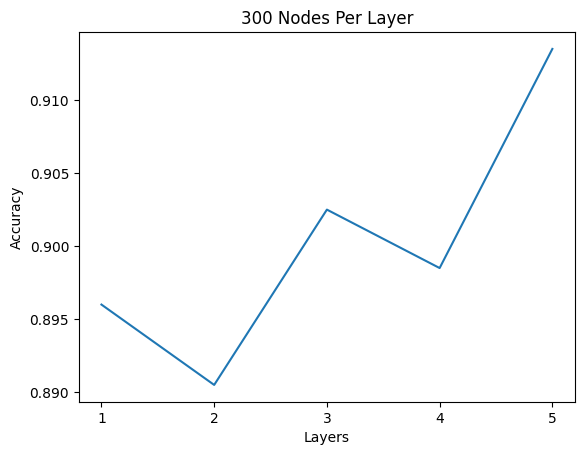

In [216]:
plt.plot(x_axis, y_axis)
plt.title('300 Nodes Per Layer')
plt.xticks(range(1,6))
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.show()

### 1 layer of 500 nodes

In [207]:
mlp1l500 = MLPClassifier(hidden_layer_sizes=(500,), verbose=True)

In [208]:
start1l500 = time.time()
mlp1l500.fit(X_train, y_train)
stop1l500 = time.time()

Iteration 1, loss = 0.36805012
Iteration 2, loss = 0.03082933
Iteration 3, loss = 0.00701822
Iteration 4, loss = 0.00313570
Iteration 5, loss = 0.00195938
Iteration 6, loss = 0.00142192
Iteration 7, loss = 0.00112655
Iteration 8, loss = 0.00095445
Iteration 9, loss = 0.00084614
Iteration 10, loss = 0.00077330
Iteration 11, loss = 0.00072149
Iteration 12, loss = 0.00068257
Iteration 13, loss = 0.00065090
Iteration 14, loss = 0.00062500
Iteration 15, loss = 0.00060256
Iteration 16, loss = 0.00058292
Iteration 17, loss = 0.00056553
Iteration 18, loss = 0.00054970
Iteration 19, loss = 0.00053521
Iteration 20, loss = 0.00052182
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [209]:
accuracy1l500 = mlp1l500.score(X_test, y_test)

In [210]:
y_pred1l500 = mlp1l500.predict(X_test)

In [211]:
print(f"Training time: {stop1l500 - start1l500:.2f} seconds")

Training time: 1338.56 seconds


In [212]:
accuracy1l500

0.89

In [213]:
print(classification_report(y_pred1l500, y_test))

              precision    recall  f1-score   support

         GPT       0.92      0.86      0.89      1020
       Human       0.87      0.92      0.89       980

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [214]:
print(confusion_matrix(y_pred1l500, y_test))

[[881 139]
 [ 81 899]]


### 1 layer of 100 nodes with logistic activation

In [125]:
mlpL = MLPClassifier(activation='logistic', verbose=True)

In [126]:
startL = time.time()
mlpL.fit(X_train, y_train)
stopL = time.time()

Iteration 1, loss = 0.57044719
Iteration 2, loss = 0.32818928
Iteration 3, loss = 0.18001943
Iteration 4, loss = 0.09848008
Iteration 5, loss = 0.05798578
Iteration 6, loss = 0.03717769
Iteration 7, loss = 0.02549038
Iteration 8, loss = 0.01884943
Iteration 9, loss = 0.01468440
Iteration 10, loss = 0.01188179
Iteration 11, loss = 0.00993002
Iteration 12, loss = 0.00849512
Iteration 13, loss = 0.00743311
Iteration 14, loss = 0.00659330
Iteration 15, loss = 0.00593275
Iteration 16, loss = 0.00540666
Iteration 17, loss = 0.00497587
Iteration 18, loss = 0.00462121
Iteration 19, loss = 0.00432336
Iteration 20, loss = 0.00406984
Iteration 21, loss = 0.00384828
Iteration 22, loss = 0.00366083
Iteration 23, loss = 0.00349265
Iteration 24, loss = 0.00334646
Iteration 25, loss = 0.00321707
Iteration 26, loss = 0.00310063
Iteration 27, loss = 0.00299520
Iteration 28, loss = 0.00290002
Iteration 29, loss = 0.00281368
Iteration 30, loss = 0.00273388
Iteration 31, loss = 0.00266034
Iteration 32, los

In [127]:
accuracyL = mlpL.score(X_test, y_test)

In [128]:
y_predL = mlpL.predict(X_test)

In [129]:
print(f"Training time: {stopL - startL:.2f} seconds")

Training time: 534.23 seconds


In [130]:
accuracyL

0.8985

In [131]:
print(classification_report(y_predL, y_test))

              precision    recall  f1-score   support

         GPT       0.90      0.89      0.90       979
       Human       0.89      0.91      0.90      1021

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [132]:
print(confusion_matrix(y_predL, y_test))

[[869 110]
 [ 93 928]]


### 2 layers of 100 nodes with logistic activation

In [217]:
mlp2l100L = MLPClassifier(hidden_layer_sizes=(100,100,), activation='logistic', verbose=True)

In [220]:
start2l100L = time.time()
mlp2l100L.fit(X_train, y_train)
stop2l100L = time.time()

Iteration 1, loss = 0.63330047
Iteration 2, loss = 0.31558846
Iteration 3, loss = 0.08612099
Iteration 4, loss = 0.02707527
Iteration 5, loss = 0.01246912
Iteration 6, loss = 0.00788686
Iteration 7, loss = 0.00577616
Iteration 8, loss = 0.00456626
Iteration 9, loss = 0.00378487
Iteration 10, loss = 0.00324646
Iteration 11, loss = 0.00285433
Iteration 12, loss = 0.00255637
Iteration 13, loss = 0.00232452
Iteration 14, loss = 0.00213937
Iteration 15, loss = 0.00198736
Iteration 16, loss = 0.00186071
Iteration 17, loss = 0.00175319
Iteration 18, loss = 0.00166123
Iteration 19, loss = 0.00158088
Iteration 20, loss = 0.00151033
Iteration 21, loss = 0.00144748
Iteration 22, loss = 0.00139121
Iteration 23, loss = 0.00134030
Iteration 24, loss = 0.00129394
Iteration 25, loss = 0.00125151
Iteration 26, loss = 0.00121231
Iteration 27, loss = 0.00117601
Iteration 28, loss = 0.00114221
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [221]:
accuracy2l100L = mlp2l100L.score(X_test, y_test)

In [222]:
y_pred2l100L = mlp2l100L.predict(X_test)

In [223]:
print(f"Training time: {stop2l100L - start2l100L:.2f} seconds")

Training time: 403.73 seconds


In [224]:
accuracy2l100L

0.9105

In [225]:
print(classification_report(y_pred2l100L, y_test))

              precision    recall  f1-score   support

         GPT       0.90      0.91      0.91       951
       Human       0.92      0.91      0.91      1049

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [226]:
print(confusion_matrix(y_pred2l100L, y_test))

[[867  84]
 [ 95 954]]


### 3 layers of 100 nodes with logistic activation

In [227]:
mlp3l100L = MLPClassifier(hidden_layer_sizes=(100,100,100,), activation='logistic', verbose=True)

In [228]:
start3l100L = time.time()
mlp3l100L.fit(X_train, y_train)
stop3l100L = time.time()

Iteration 1, loss = 0.67492883
Iteration 2, loss = 0.34710158
Iteration 3, loss = 0.05995760
Iteration 4, loss = 0.01442557
Iteration 5, loss = 0.00704847
Iteration 6, loss = 0.00456999
Iteration 7, loss = 0.00356768
Iteration 8, loss = 0.00294544
Iteration 9, loss = 0.00252252
Iteration 10, loss = 0.00221344
Iteration 11, loss = 0.00197859
Iteration 12, loss = 0.00179331
Iteration 13, loss = 0.00164390
Iteration 14, loss = 0.00152044
Iteration 15, loss = 0.00141657
Iteration 16, loss = 0.00132780
Iteration 17, loss = 0.00125089
Iteration 18, loss = 0.00118370
Iteration 19, loss = 0.00112427
Iteration 20, loss = 0.00107121
Iteration 21, loss = 0.00102363
Iteration 22, loss = 0.00098044
Iteration 23, loss = 0.00094124
Iteration 24, loss = 0.00090535
Iteration 25, loss = 0.00087231
Iteration 26, loss = 0.00084184
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [229]:
accuracy3l100L = mlp3l100L.score(X_test, y_test)

In [230]:
y_pred3l100L = mlp3l100L.predict(X_test)

In [231]:
print(f"Training time: {stop3l100L - start3l100L:.2f} seconds")

Training time: 372.90 seconds


In [232]:
accuracy3l100L

0.912

In [233]:
print(classification_report(y_pred3l100L, y_test))

              precision    recall  f1-score   support

         GPT       0.91      0.91      0.91       962
       Human       0.92      0.92      0.92      1038

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [234]:
print(confusion_matrix(y_pred3l100L, y_test))

[[874  88]
 [ 88 950]]


### 4 layers of 100 nodes with logistic activation

In [235]:
mlp4l100L = MLPClassifier(hidden_layer_sizes=(100,100,100,100,), activation='logistic', verbose=True)

In [236]:
start4l100L = time.time()
mlp4l100L.fit(X_train, y_train)
stop4l100L = time.time()

Iteration 1, loss = 0.69903288
Iteration 2, loss = 0.61030315
Iteration 3, loss = 0.16851468
Iteration 4, loss = 0.03679102
Iteration 5, loss = 0.01600032
Iteration 6, loss = 0.00869534
Iteration 7, loss = 0.00574242
Iteration 8, loss = 0.00453859
Iteration 9, loss = 0.00375538
Iteration 10, loss = 0.00320402
Iteration 11, loss = 0.00279447
Iteration 12, loss = 0.00247862
Iteration 13, loss = 0.00222756
Iteration 14, loss = 0.00202356
Iteration 15, loss = 0.00185437
Iteration 16, loss = 0.00171193
Iteration 17, loss = 0.00159029
Iteration 18, loss = 0.00148546
Iteration 19, loss = 0.00139400
Iteration 20, loss = 0.00131351
Iteration 21, loss = 0.00124225
Iteration 22, loss = 0.00117863
Iteration 23, loss = 0.00112153
Iteration 24, loss = 0.00106997
Iteration 25, loss = 0.00102317
Iteration 26, loss = 0.00098055
Iteration 27, loss = 0.00094150
Iteration 28, loss = 0.00090561
Iteration 29, loss = 0.00087256
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. S

In [237]:
accuracy4l100L = mlp4l100L.score(X_test, y_test)

In [238]:
y_pred4l100L = mlp4l100L.predict(X_test)

In [239]:
print(f"Training time: {stop4l100L - start4l100L:.2f} seconds")

Training time: 394.22 seconds


In [240]:
accuracy4l100L

0.906

In [241]:
print(classification_report(y_pred4l100L, y_test))

              precision    recall  f1-score   support

         GPT       0.90      0.90      0.90       958
       Human       0.91      0.91      0.91      1042

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [242]:
print(confusion_matrix(y_pred4l100L, y_test))

[[866  92]
 [ 96 946]]


### 5 layers of 100 nodes with logistic activation

In [243]:
mlp5l100L = MLPClassifier(hidden_layer_sizes=(100,100,100,100,100,), activation='logistic', verbose=True)

In [244]:
start5l100L = time.time()
mlp5l100L.fit(X_train, y_train)
stop5l100L = time.time()

Iteration 1, loss = 0.69492037
Iteration 2, loss = 0.62672266
Iteration 3, loss = 0.15196998
Iteration 4, loss = 0.04081852
Iteration 5, loss = 0.01742213
Iteration 6, loss = 0.00917427
Iteration 7, loss = 0.00529074
Iteration 8, loss = 0.00363399
Iteration 9, loss = 0.00296145
Iteration 10, loss = 0.00250455
Iteration 11, loss = 0.00217113
Iteration 12, loss = 0.00191739
Iteration 13, loss = 0.00171791
Iteration 14, loss = 0.00155703
Iteration 15, loss = 0.00142483
Iteration 16, loss = 0.00131427
Iteration 17, loss = 0.00122060
Iteration 18, loss = 0.00114020
Iteration 19, loss = 0.00107057
Iteration 20, loss = 0.00100967
Iteration 21, loss = 0.00095598
Iteration 22, loss = 0.00090834
Iteration 23, loss = 0.00086577
Iteration 24, loss = 0.00082755
Iteration 25, loss = 0.00079300
Iteration 26, loss = 0.00076167
Iteration 27, loss = 0.00073311
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [245]:
accuracy5l100L = mlp5l100L.score(X_test, y_test)

In [246]:
y_pred5l100L = mlp5l100L.predict(X_test)

In [247]:
print(f"Training time: {stop5l100L - start5l100L:.2f} seconds")

Training time: 368.45 seconds


In [248]:
accuracy5l100L

0.9055

In [249]:
print(classification_report(y_pred5l100L, y_test))

              precision    recall  f1-score   support

         GPT       0.90      0.90      0.90       959
       Human       0.91      0.91      0.91      1041

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [250]:
print(confusion_matrix(y_pred5l100L, y_test))

[[866  93]
 [ 96 945]]


In [253]:
x_axis=[1,2,3,4,5]
y_axis=[accuracyL,accuracy2l100L,accuracy3l100L,accuracy4l100L,accuracy5l100L]

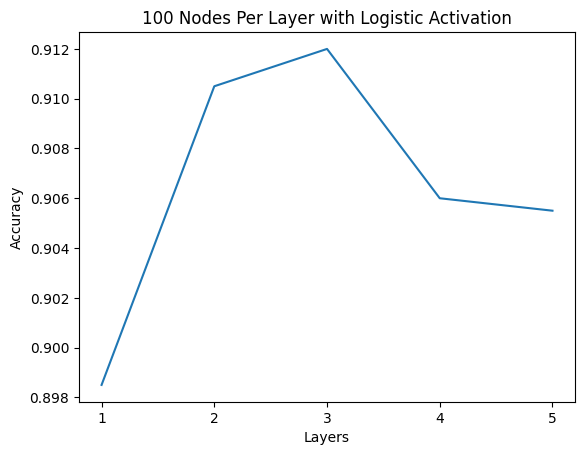

In [254]:
plt.plot(x_axis, y_axis)
plt.title('100 Nodes Per Layer with Logistic Activation')
plt.xticks(range(1,6))
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.show()

In [105]:
vocab = vectorizer.vocabulary_

In [106]:
new_vectorizer = CountVectorizer(vocabulary=vocab)

In [107]:
Test = "The moon is a celestial object that orbits around the Earth and is the fifth largest natural satellite in the solar system. It has a rocky surface that is covered in craters, mountains, and vast plains called maria, which are made up of hardened lava flows. The moon has no atmosphere and is not capable of supporting life, but it does have a gravitational pull that affects the tides on Earth. The moon's phases, which are caused by its position relative to the sun and Earth, have played an important role in human culture and mythology for centuries. Humans have landed on the moon several times, with the first landing occurring in 1969 during the Apollo 11 mission. The study of the moon continues to be an important area of research for scientists and astronomers seeking to better understand the history and formation of the solar system."

In [108]:
Test_features = new_vectorizer.transform([Test])

In [109]:
mlp.predict(Test_features)[0]

'GPT'